# Introduction

As analysts engaged by Oasis Bank to investigate their customer churn rate, we are tasked with examining a dataset comprising various customer attributes and behaviors. This dataset includes information such as credit scores, geographic location, gender, age, tenure, balance, and more, for a sample of Oasis Bank's customers. Our primary objective is to utilize this dataset to understand the factors contributing to customer churn within Oasis Bank's customer base. By leveraging statistical analysis and machine learning techniques, we aim to uncover insights that will help Oasis Bank mitigate customer attrition, enhance customer satisfaction, and improve overall business performance.

## Objectives

- Analyze customer churn within Oasis Bank's customer base.
- Identify key factors influencing customer attrition.
- Utilize statistical analysis and machine learning to uncover actionable insights.
- Provide recommendations to improve customer retention strategies.


## Approach

We'll use advanced methods like predictive modeling and cluster analysis to find useful insights. These insights will help us suggest specific strategies to keep customers from leaving Oasis Bank. Our approach relies on data, making sure our suggestions are based on real evidence and match the issues Oasis Bank is dealing with.




In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=48c46cf552f953b4b2ff8fd977fee2c95973001436a1d2b9a984cae670b25583
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Files used to create our Master dataset:

1. **Customer Details**:  
   - **Features:** Customer Id, Surname, Geography, Gender, Age, Estimated Salary.

2. **Bank Details**:  
   - **Features:** Customer Id, Credit Score, Tenure, Balance, Exited, Complain, Satisfaction Score.

3. **Product Details**:  
   - **Features:** CustomerId, NumOfProducts, HasCrCard, IsActiveMember, CardType, PointsEarner.


# Creating master data set

In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("BankProject").getOrCreate()

In [ ]:
cust_data=spark.read.csv('Customer_details.csv', header=True, inferSchema=True)
bank_data=spark.read.csv('Bank_details.csv', header=True, inferSchema=True)
prod_data=spark.read.csv('Product_details.csv', header=True, inferSchema=True)

In [ ]:
cust_data.show(2, truncate=False)
bank_data.show(2, truncate=False)
prod_data.show(2, truncate=False)

+----------+--------+---------+------+---+---------------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|
+----------+--------+---------+------+---+---------------+
|15634602  |Hargrave|France   |Female|42 |101348.88      |
|15647311  |Hill    |Spain    |Female|41 |112542.58      |
+----------+--------+---------+------+---+---------------+
only showing top 2 rows

+----------+-----------+------+--------+------+--------+-----------------+
|CustomerId|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|
+----------+-----------+------+--------+------+--------+-----------------+
|15634602  |619        |2     |0.0     |1     |1       |2                |
|15647311  |608        |1     |83807.86|0     |1       |3                |
+----------+-----------+------+--------+------+--------+-----------------+
only showing top 2 rows

+----------+-------------+---------+--------------+--------+-----------+
|CustomerId|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|


In [ ]:
master_data = cust_data.join(bank_data,["CustomerId"])
master_data = master_data.join(prod_data,["CustomerId"])


# Display the first 2 records of the joined data
master_data.show(2,truncate=False)

+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|
+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+
|15634602  |Hargrave|France   |Female|42 |101348.88      |619        |2     |0.0     |1     |1       |2                |1            |1        |1             |DIAMOND |464        |
|15647311  |Hill    |Spain    |Female|41 |112542.58      |608        |1     |83807.86|0     |1       |3                |1            |0        |1             |DIAMOND |456        |
+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--

## Customer Demographics Analysis

In [ ]:
from pyspark.sql.functions import col, when


#Grouping using sum () function on the basis of Department and Gender
result1 = master_data.groupBy("Geography", "Gender").count().orderBy("Geography", "Gender")

# Show the result with organized order
result1.show(truncate=False)


# Assuming master_data is your DataFrame
result2 = master_data.select(
    (
        when((col("Age").between(18, 25)), "18-25")
        .when((col("Age").between(26, 35)), "26-35")
        .when((col("Age").between(36, 45)), "36-45")
        .when((col("Age").between(46, 55)), "46-55")
        .when((col("Age").between(56, 65)), "56-65")
        .otherwise("66+").alias("AgeGroup")
    )
).groupBy("AgeGroup").count().orderBy("AgeGroup")

result2.show()

+---------+------+-----+
|Geography|Gender|count|
+---------+------+-----+
|France   |Female|2261 |
|France   |Male  |2753 |
|Germany  |Female|1193 |
|Germany  |Male  |1316 |
|Spain    |Female|1089 |
|Spain    |Male  |1388 |
+---------+------+-----+

+--------+-----+
|AgeGroup|count|
+--------+-----+
|   18-25|  611|
|   26-35| 3542|
|   36-45| 3736|
|   46-55| 1311|
|   56-65|  536|
|     66+|  264|
+--------+-----+



**Geographical and Gender Distribution:**
*   France has the highest number of customers, followed by Germany and Spain.
*   In each country, there are more male customers than female customers.



**Age Distribution:**
The observations from the age distribution data suggest that the bank's products and services are currently most appealing to middle-aged customers, particularly those between 26 and 45 years old. The lower customer counts in the younger (18-25) and older (46+) age brackets indicate that these segments might not be fully tapped or might find the bank's offerings less appealing or relevant.

## Financial Health Assessment

In [ ]:
#Average balance and credit score by geography
average_data = master_data.groupBy("Geography").agg(
    {"Balance": "avg", "CreditScore": "avg"}
).withColumnRenamed("avg(Balance)", "AverageBalance").withColumnRenamed("avg(CreditScore)", "AverageCreditScore").orderBy("Geography")

average_data.show()

#Customer segments based on balance and credit score
segment_data = master_data.select(
    when((col("Balance") > 100000) & (col("CreditScore") > 700), "High-Value Low-Risk")
    .when((col("Balance") < 100000) & (col("CreditScore") > 700), "Low-Value Low-Risk")
    .when((col("Balance") > 100000) & (col("CreditScore") <= 700), "High-Value High-Risk")
    .otherwise("Low-Value High-Risk")
    .alias("Segment")
).groupBy("Segment").count()

segment_data.show()

+---------+------------------+------------------+
|Geography|AverageCreditScore|    AverageBalance|
+---------+------------------+------------------+
|   France| 649.6683286796969|  62092.6365157559|
|  Germany| 651.4535671582304|119730.11613391782|
|    Spain| 651.3338716188938| 61818.14776342349|
+---------+------------------+------------------+

+--------------------+-----+
|             Segment|count|
+--------------------+-----+
| Low-Value High-Risk| 3586|
|  Low-Value Low-Risk| 1615|
|High-Value High-Risk| 3298|
| High-Value Low-Risk| 1501|
+--------------------+-----+



**Geographic Financial Trends:** Customers in Germany tend to have higher average balances compared to those in France and Spain, suggesting stronger financial engagement or wealth accumulation among German customers. Despite these differences in balances, the average credit scores are relatively consistent across the countries, indicating similar creditworthiness among the bank's clientele in these regions.

**Customer Risk Segmentation:** A significant portion of the bank's customers fall into the "Low-Value High-Risk" and "High-Value High-Risk" segments, suggesting that many customers either have lower balances with higher risk or higher balances with higher risk. The presence of a substantial "High-Value Low-Risk" segment indicates a solid customer base with good financial standing and low risk. The bank might consider developing targeted strategies to migrate customers from high-risk to low-risk segments while also focusing on increasing the value of low-value customers.

## Risk and Churn Analysis

In [ ]:
# Identifying churn rates by product and card types

churn_data = master_data.groupBy("NumOfProducts", "CardType").agg(
    {"Exited": "avg"}
).withColumnRenamed("avg(Exited)", "ChurnRate").orderBy("NumOfProducts", "CardType")

churn_data.show()

+-------------+--------+-------------------+
|NumOfProducts|CardType|          ChurnRate|
+-------------+--------+-------------------+
|            1| DIAMOND| 0.2828054298642534|
|            1|    GOLD|0.26242236024844723|
|            1|PLATINUM|0.27339300244100895|
|            1|  SILVER|  0.290088638195004|
|            2| DIAMOND|0.08949771689497717|
|            2|    GOLD|0.06748466257668712|
|            2|PLATINUM|0.08013640238704177|
|            2|  SILVER|0.06773920406435224|
|            3| DIAMOND| 0.8169014084507042|
|            3|    GOLD| 0.8909090909090909|
|            3|PLATINUM| 0.8051948051948052|
|            3|  SILVER| 0.8095238095238095|
|            4| DIAMOND|                1.0|
|            4|    GOLD|                1.0|
|            4|PLATINUM|                1.0|
|            4|  SILVER|                1.0|
+-------------+--------+-------------------+



**Product and Churn Relationship:** Customers with one product have moderate churn rates across different card types, indicating potential dissatisfaction or unmet needs. The churn rate drastically decreases for customers with two products, suggesting higher satisfaction or engagement at this level. However, customers with three or four products exhibit extremely high to total churn rates, signaling potential issues with service or product offerings for these segments.

**Card Type and Churn Correlation:** Among customers with one or two products, churn rates vary slightly by card type, but not significantly. However, for customers with three or four products, the churn rate reaches alarming levels, irrespective of the card type, indicating that the number of products might be a stronger predictor of churn than the type of card.

## Loyalty and Satisfaction Exploration

In [ ]:
#Satisfaction scores across different customer segments

segment_data = master_data.withColumn(
    "Segment",
    when((col("Balance") > 100000) & (col("CreditScore") > 700), "High-Value Low-Risk")
    .when((col("Balance") < 100000) & (col("CreditScore") > 700), "Low-Value Low-Risk")
    .when((col("Balance") > 100000) & (col("CreditScore") <= 700), "High-Value High-Risk")
    .otherwise("Low-Value High-Risk")
).groupBy("Segment").agg({"SatisfactionScore": "avg"}).withColumnRenamed("avg(SatisfactionScore)", "AvgSatisfaction")

segment_data.show()

#Correlation between satisfaction score and churn

churn_data = master_data.groupBy("SatisfactionScore").agg({"Exited": "avg"}).withColumnRenamed("avg(Exited)", "ChurnRate").orderBy("SatisfactionScore")

churn_data.show()

+--------------------+------------------+
|             Segment|   AvgSatisfaction|
+--------------------+------------------+
| Low-Value High-Risk| 3.053820412716118|
|  Low-Value Low-Risk|2.9622291021671825|
|High-Value High-Risk|2.9978775015160704|
| High-Value Low-Risk|3.0086608927381744|
+--------------------+------------------+

+-----------------+-------------------+
|SatisfactionScore|          ChurnRate|
+-----------------+-------------------+
|                1|0.20031055900621117|
|                2|  0.217974180734856|
|                3|0.19637610186092067|
|                4| 0.2061752988047809|
|                5|0.19810379241516965|
+-----------------+-------------------+




**Satisfaction Across Segments:** Customer satisfaction levels are relatively similar across different financial segments, with all averages hovering around the 3 out of 5 marks. Notably, there's no significant satisfaction gap between high-value and low-value customers, nor between high-risk and low-risk customers, suggesting that the bank's services might be perceived as consistently average across different customer financial profiles.

**Satisfaction and Churn Correlation:** There doesn't appear to be a strong direct correlation between satisfaction scores and churn rates. Customers with the lowest (1) and slightly higher (2) satisfaction scores exhibit higher churn rates, which aligns with expectations. However, the churn rate does not progressively decrease with higher satisfaction scores; it fluctuates slightly, suggesting that factors other than satisfaction might be influencing customers' decisions to exit. This indicates that improving satisfaction scores alone may not be sufficient to significantly reduce churn rates; a deeper investigation into other contributing factors is necessary.

##Pyspark Live Streaming

In [ ]:
#Reading the data
custdata=spark.read.csv('Customer-Churn-Records.csv', header=True, inferSchema=True)

#Reading the stream of data by specifying the schema and directory
custdata_stream=spark.readStream.schema(custdata.schema).csv('CustDir/')

#Writing the stream of data to a table named emptable
#The output mode is append which means that the data will be added always to existing table
empquery=custdata_stream.writeStream.queryName("Custtable").format("memory").outputMode("append").start()

In [ ]:
#Copy the EmployeeAttrition.csv file to the Attrition folder
import shutil
src=r"Customer-Churn-Records.csv"
dest = r"CustDir"
shutil.copy(src,dest)

'CustDir/Customer-Churn-Records.csv'

In [ ]:
spark.sql("select Geography,SUM(Exited) AS Exited_Count,SUM(Complain) AS Complain_Count,AVG(`Satisfaction Score`) AS Avg_Satisfaction_Score FROM Custtable GROUP BY Geography").show()

+---------+------------+--------------+----------------------+
|Geography|Exited_Count|Complain_Count|Avg_Satisfaction_Score|
+---------+------------+--------------+----------------------+
|  Germany|         814|           819|    3.0059784774810683|
|   France|         811|           812|    3.0177502991623455|
|    Spain|         413|           413|     3.013726281792491|
|Geography|        NULL|          NULL|                  NULL|
+---------+------------+--------------+----------------------+



In [ ]:
#Displaying the number of records after adding the copy of file to the folder
import time
for i in range (5):
    spark.sql("select Geography,SUM(Exited) AS Exited_Count,SUM(Complain) AS Complain_Count,AVG(`Satisfaction Score`) AS Avg_Satisfaction_Score FROM Custtable GROUP BY Geography").show()
    newfile="CustDir/GeographyDetails" + str(i) +  ".csv"
    shutil.copy(src,newfile)
    time.sleep(5)

+---------+------------+--------------+----------------------+
|Geography|Exited_Count|Complain_Count|Avg_Satisfaction_Score|
+---------+------------+--------------+----------------------+
|  Germany|         814|           819|    3.0059784774810683|
|   France|         811|           812|    3.0177502991623455|
|    Spain|         413|           413|     3.013726281792491|
|Geography|        NULL|          NULL|                  NULL|
+---------+------------+--------------+----------------------+

+---------+------------+--------------+----------------------+
|Geography|Exited_Count|Complain_Count|Avg_Satisfaction_Score|
+---------+------------+--------------+----------------------+
|  Germany|        1628|          1638|    3.0059784774810683|
|   France|        1622|          1624|    3.0177502991623455|
|    Spain|         826|           826|     3.013726281792491|
|Geography|        NULL|          NULL|                  NULL|
+---------+------------+--------------+---------------

**Churn Analysis by Geography**

- Germany has the highest number of customer exits, followed closely by France, while Spain has the lowest churn rate.
- Despite Germany having a higher number of customer exits, its average satisfaction score is relatively close to that of France and Spain.

**Complaint Counts:**

- Complaint counts are nearly equivalent to the number of customer exits in each geographical region, indicating a potential correlation between complaints and churn.

**Average Satisfaction Score:**

- The average satisfaction score across all geographical regions is above 3, suggesting a moderate level of satisfaction among customers.
- There is minimal variation in the average satisfaction scores among the different regions.

## **Suggestions:**

**Germany and France:**

- To investigate the root causes behind the higher churn rates in Germany and France.We can conduct customer surveys, feedback analysis, and sentiment analysis to identify common pain points and areas for improvement.
- To focus on enhancing customer service and support in these regions to address customer complaints promptly and effectively.
- Implement targeted retention strategies such as personalized offers, loyalty programs, and proactive outreach to dissatisfied customers.

**Spain:**

- Explore the factors contributing to the lower churn rate in Spain and identify best practices that can be replicated in other regions.
- Leverage customer satisfaction insights from Spain to enhance overall service quality and customer experience across all regions.
- Encourage customer engagement and loyalty through exclusive promotions, rewards, and incentives tailored to the preferences of Spanish customers.

**Overall Strategy:**

- Emphasize the importance of proactive customer relationship management and continuous improvement initiatives to reduce churn rates across all geographical regions.
- Foster a customer-centric culture within the organization by prioritizing customer feedback, addressing pain points, and delivering exceptional service.
- Leverage advanced analytics and predictive modeling techniques to forecast churn trends, identify at-risk customers, and implement preventive measures proactively.

By addressing the underlying issues contributing to churn, optimizing customer satisfaction, and implementing targeted retention strategies, the company can enhance customer loyalty, drive sustainable growth, and foster long-term success in the highly competitive market landscape.


# Unsupervised ML Technique - Clustering : KMeans    
Let's divide the customers in different clusters to understand which group of customers is having the highest churn rate. Moreover, for the clusters having high churn rate we tried to find the different factors that might be common between the clusters.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

#Creating a function
def set_cardtype(cardtype):
    if cardtype=="SILVER":
        return 1
    elif cardtype=="GOLD":
        return 2
    elif cardtype=="DIAMOND":
        return 3
    elif cardtype=="PLATINUM":
        return 4
    else:
        return 0

#Creating a user defined function
set_udf=udf(set_cardtype,StringType())

#Adding a new column containing value based on user defined function
master_data=master_data.withColumn('CardTypeImp',set_udf(master_data['CardType']))

#Displaying the results
master_data.select("CardType","CardTypeImp").show(5)

+--------+-----------+
|CardType|CardTypeImp|
+--------+-----------+
| DIAMOND|          3|
| DIAMOND|          3|
| DIAMOND|          3|
|    GOLD|          2|
|    GOLD|          2|
+--------+-----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from  pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans

str_rec=StringIndexer(inputCols=["Geography","Gender","Exited","IsActiveMember","CardTypeImp","HasCrCard","Complain"],
                      outputCols=["newGeography","newGender","newExited","newIsActiveMember","newCardTypeImp","newHasCrCard","newComplain"], stringOrderType="alphabetAsc")

onehot_rec=OneHotEncoder(inputCols=["newGeography","newGender","newIsActiveMember","newExited","newHasCrCard","newComplain"],
                         outputCols=["newGeography2","newGender2","newIsActiveMember2","newExited2","newHasCrCard2","newComplain2"])

vec_rec=VectorAssembler(inputCols=["newGeography2","newGender2","newIsActiveMember2","newExited2","newHasCrCard2",
                                   "Age","EstimatedSalary","CreditScore","Tenure","Balance","SatisfactionScore","NumOfProducts","PointEarned","newComplain2"],
                        outputCol="all_features")

kmeans=KMeans(featuresCol="all_features").setK(4).setSeed(123)
kmeanspipeline=Pipeline(stages=[str_rec,onehot_rec,vec_rec,kmeans])
kmeansresult=kmeanspipeline.fit(master_data).transform(master_data)
kmeansresult.show()

+----------+---------+---------+------+---+---------------+-----------+------+---------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+-----------+------------+---------+---------+-----------------+--------------+------------+-----------+-------------+-------------+------------------+-------------+-------------+-------------+--------------------+----------+
|CustomerId|  Surname|Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|  Balance|Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|CardTypeImp|newGeography|newGender|newExited|newIsActiveMember|newCardTypeImp|newHasCrCard|newComplain|newGeography2|   newGender2|newIsActiveMember2|   newExited2|newHasCrCard2| newComplain2|        all_features|prediction|
+----------+---------+---------+------+---+---------------+-----------+------+---------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+----

In [ ]:
churn_rate = kmeansresult.groupBy("prediction").agg({"Exited":"avg"}).withColumnRenamed("avg(Exited)", "ChurnRate").orderBy("ChurnRate",ascending =False)
churn_rate.show()

+----------+-------------------+
|prediction|          ChurnRate|
+----------+-------------------+
|         0|0.24329501915708812|
|         3|0.23752039151712886|
|         1| 0.1498147167813658|
|         2|0.13845350052246605|
+----------+-------------------+



In [ ]:
filtered_data = kmeansresult.filter((kmeansresult['prediction']==0) | (kmeansresult['prediction']==3)).select('prediction','EstimatedSalary','Age','Tenure','Complain')
reasons = filtered_data.groupBy('prediction').agg({"EstimatedSalary":"avg","Age":"avg","Tenure":"avg","Complain":"avg"})
reasons.show()

+----------+-----------------+-------------------+--------------------+------------------+
|prediction|      avg(Tenure)|      avg(Complain)|avg(EstimatedSalary)|          avg(Age)|
+----------+-----------------+-------------------+--------------------+------------------+
|         3|4.961500815660685|0.23784665579119085|   50469.45139641121|39.405546492659056|
|         0|5.002554278416348|0.24489144316730524|  149729.90698595162| 38.98371647509578|
+----------+-----------------+-------------------+--------------------+------------------+



## Inference:
From this above results we can see that, cluster 0 and cluster 3 are having higher churn rate and after looking at the features like Tenure, EstimatedSalary, Age, and Complain the similarities between these features is evidently visible except the salary feature. It is due to this feature we are able to distinguish between these clusters

# Machine Learning Models - Predicting which customers are likely to exit the bank   

Now to predict which customers are more likely to exit the bank, we have used three machine learning models logistic classifier, decision tree classifier and random forest models. Our target variable here is Exited and rest others are our predicters. Firstly, we took all the categorical features and converted them into numerical values using string indexing and one-hot encoding. Then we fused all the features using the Vector Assembler and then used the ML models to predict our target variable that surprisingly resulted in very high accuracy.

In [ ]:
str_obj=StringIndexer(inputCols=["Geography","Gender","Exited","IsActiveMember","CardTypeImp","HasCrCard","Complain"],
                      outputCols=["newGeography","newGender","newExited","newIsActiveMember","newCardTypeImp","newHasCrCard","newComplain"], stringOrderType="alphabetAsc")


onehot_obj=OneHotEncoder(inputCols=["newGeography","newGender","newIsActiveMember","newCardTypeImp","newHasCrCard","newComplain"],
                         outputCols=["newGeography2","newGender2","newIsActiveMember2","newCardTypeImp2","newHasCrCard2","newComplain2"])

vec_obj=VectorAssembler(inputCols=["newGeography2","newGender2","newIsActiveMember2","newCardTypeImp2","newHasCrCard2",
                                   "newComplain2","Age","EstimatedSalary","CreditScore","Tenure","Balance","SatisfactionScore","NumOfProducts","PointEarned"],
                        outputCol="all_features")

**Logistic Regression Model**

In [ ]:
#Creating a logistic regression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='all_features', labelCol="newExited")

#Creating a pipeline
lrpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,lr])

#Splitting the dataset in training and test
training, test=master_data.randomSplit([0.7,0.3],seed=123)

#Training the model
lrmodel=lrpipeline.fit(training)

#Predicting the results on test dataset
lrresults=lrmodel.transform(test)

#Displaying the results
lrresults.show(2, truncate=False)

+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+-----------+------------+---------+---------+-----------------+--------------+------------+-----------+-------------+----------+------------------+---------------+-------------+-------------+------------------------------------------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|CardTypeImp|newGeography|newGender|newExited|newIsActiveMember|newCardTypeImp|newHasCrCard|newComplain|newGeography2|newGender2|newIsActiveMember2|newCardTypeImp2|newHasCrCard2|newComplain2 |all_features                                                                  

In [ ]:
#Determining the accuracy
def calc_accuracy(results):
  results=results.withColumn("compare",results['newExited']-results['prediction'])
  correct=results.filter(results['compare']==0).count()
  incorrect=results.filter(results['compare']!=0).count()
  return(correct/(correct+incorrect))

print("Accuracy for logistic classifier model is: ",calc_accuracy(lrresults))

Accuracy for logistic classifier model is:  0.9986953685583823


**Decision Tree Model**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
tree=DecisionTreeClassifier(featuresCol='all_features', labelCol="newExited")
treepipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,tree])
training, test=master_data.randomSplit([0.7,0.3], seed=123)
treemodel=treepipeline.fit(training)
treeresults=treemodel.transform(test)
treeresults.show(2, truncate=False)

print("Accuracy for Decision Tree classifier model is: ",calc_accuracy(treeresults))

+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+-----------+------------+---------+---------+-----------------+--------------+------------+-----------+-------------+----------+------------------+---------------+-------------+-------------+------------------------------------------------------------------------------------+-------------+------------------------------------------+----------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|CardTypeImp|newGeography|newGender|newExited|newIsActiveMember|newCardTypeImp|newHasCrCard|newComplain|newGeography2|newGender2|newIsActiveMember2|newCardTypeImp2|newHasCrCard2|newComplain2 |all_features                                                                        |rawPrediction|proba

**Random Forest Tree Model**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
forest=RandomForestClassifier(featuresCol='all_features', labelCol="newSatisfaction")
forestpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,tree])
training, test=master_data.randomSplit([0.8,0.2], seed=123)
forestmodel=forestpipeline.fit(training)
forestresults=forestmodel.transform(test)
forestresults.show(2, truncate=False)

print("Accuracy for Decision Tree classifier model is: ",calc_accuracy(forestresults))

+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+-----------+------------+---------+---------+-----------------+--------------+------------+-----------+-------------+----------+------------------+---------------+-------------+-------------+------------------------------------------------------------------------------------+-------------+------------------------------------------+----------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|CardTypeImp|newGeography|newGender|newExited|newIsActiveMember|newCardTypeImp|newHasCrCard|newComplain|newGeography2|newGender2|newIsActiveMember2|newCardTypeImp2|newHasCrCard2|newComplain2 |all_features                                                                        |rawPrediction|proba

As we saw very high accuracy, we decided to check the bias and variance in our data. After plotting the below plot we found that features like - "NumofProducts","age" and "complain" are the highly influencing features for the target variable.

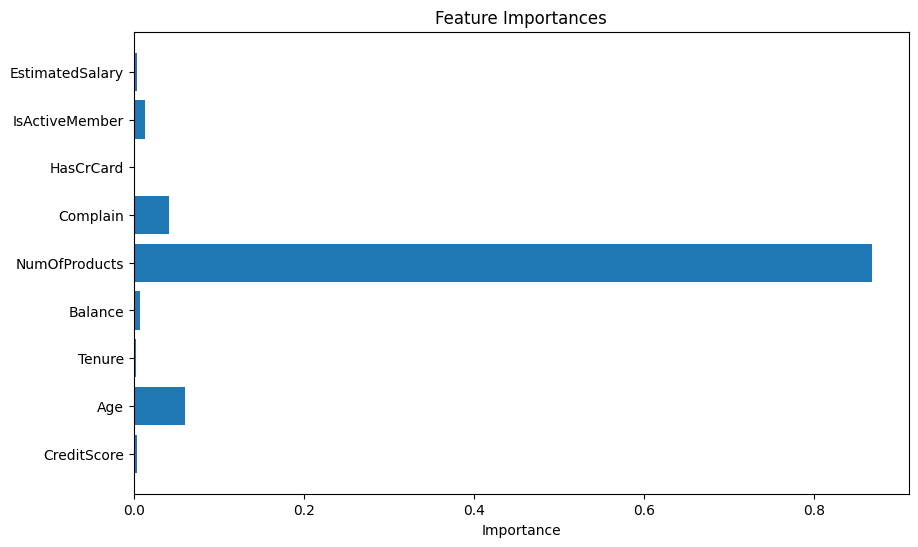

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming you have a Spark DataFrame named 'df' containing your data
# Assuming the target variable is named 'Exited' and other features are your independent variables

# Vector Assembler to combine features into a single vector
assembler = VectorAssembler(inputCols=["CreditScore", "Age", "Tenure", "Balance","Complain","NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"], outputCol="features")
df_assembled = assembler.transform(master_data)

# Splitting data into training and testing sets
(train_data, test_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Exited", featuresCol="features", numTrees=500, maxDepth=10)
model_rf = rf.fit(train_data)

# Extracting feature importances
importances = model_rf.featureImportances.toArray()

# Creating lists for feature names and importances
feature_names = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts","Complain", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()



**NumOfProducts:** "NumOfProducts" feature being the most important feature indicates that the number of products or services a customer is subscribed to is a strong predictor of churn. Customers with a higher number of products may churn for various reasons, such as dissatisfaction with specific products, excessive fees, or lack of personalized service. On the other hand, customers with fewer products may churn due to limited engagement with the bank. Analyzing the relationship between the number of products and churn can provide insights into cross-selling strategies, product bundling, and personalized recommendations to enhance customer retention.


**Age:** The "Age" feature being the second most important feature suggests that customer age plays a significant role in predicting churn. Younger or older customers may exhibit different churn behaviors. For example, younger customers may be more prone to switching banks due to life events such as relocation or changing financial priorities, while older customers may churn due to retirement or changes in their financial needs. Understanding these age-related churn patterns can help tailor retention strategies targeted towards specific age groups.

**Complain:** The importance of the "Complain" feature indicates whether
customer complaints have a significant impact on predicting churn. A higher importance suggests that customers who have previously raised complaints are more likely to churn. This could imply that addressing customer complaints effectively may be crucial in retaining customers and reducing churn rates. Identifying the root causes of complaints and taking proactive measures to address them could potentially improve customer satisfaction and loyalty.







In [ ]:
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["Geography","Gender","Exited","IsActiveMember","CardTypeImp","HasCrCard"],
                      outputCols=["newGeography","newGender","newExited","newIsActiveMember","newCardTypeImp","newHasCrCard"], stringOrderType="alphabetAsc")


from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newGeography","newGender","newIsActiveMember","newCardTypeImp","newHasCrCard"],
                         outputCols=["newGeography2","newGender2","newIsActiveMember2","newCardTypeImp2","newHasCrCard2"])

from  pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["newGeography2","newGender2","newIsActiveMember2","newCardTypeImp2","newHasCrCard2",
                                   "EstimatedSalary","CreditScore","Tenure","Balance","SatisfactionScore","PointEarned"],
                        outputCol="all_features")

**Logistic Regression**

In [ ]:
#Creating a logistic regression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='all_features', labelCol="newExited")

#Creating a pipeline
from pyspark.ml import Pipeline
lrpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,lr])

#Splitting the dataset in training and test
training, test=master_data.randomSplit([0.7,0.3],seed=123)
#Training the model
lrmodel=lrpipeline.fit(training)

#Predicting the results on test dataset
lrresults=lrmodel.transform(test)

#Displaying the results
lrresults.show(2, truncate=False)

#Determining the accuracy
print("Accuracy for logistic classifier model is: ",calc_accuracy(lrresults))

+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+-----------+------------+---------+---------+-----------------+--------------+------------+-------------+----------+------------------+---------------+-------------+-----------------------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|CardTypeImp|newGeography|newGender|newExited|newIsActiveMember|newCardTypeImp|newHasCrCard|newGeography2|newGender2|newIsActiveMember2|newCardTypeImp2|newHasCrCard2|all_features                                                           |rawPrediction                           |probability                    

**Decision Tree**

In [ ]:
tree=DecisionTreeClassifier(featuresCol='all_features', labelCol="newExited")
treepipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,tree])
training, test=master_data.randomSplit([0.7,0.3], seed=123)
treemodel=treepipeline.fit(training)
treeresults=treemodel.transform(test)
treeresults.show(2, truncate=False)

print("Accuracy for Decision Tree classifier model is: ",calc_accuracy(treeresults))

+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+-----------+------------+---------+---------+-----------------+--------------+------------+-------------+----------+------------------+---------------+-------------+-----------------------------------------------------------------------+--------------+----------------------------------------+----------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|CardTypeImp|newGeography|newGender|newExited|newIsActiveMember|newCardTypeImp|newHasCrCard|newGeography2|newGender2|newIsActiveMember2|newCardTypeImp2|newHasCrCard2|all_features                                                           |rawPrediction |probability                             |prediction|
+----------+--------+---------

**Random Forest Classifier**

In [ ]:
forest=RandomForestClassifier(featuresCol='all_features', labelCol="newExited")
forestpipeline=Pipeline(stages=[str_obj,onehot_obj,vec_obj,forest])
training, test=master_data.randomSplit([0.7,0.3], seed=123)
forestmodel=forestpipeline.fit(training)
forestresults=forestmodel.transform(test)
forestresults.show(2, truncate=False)

print("Accuracy for Random Forest classifier model is: ",calc_accuracy(forestresults))

+----------+--------+---------+------+---+---------------+-----------+------+--------+------+--------+-----------------+-------------+---------+--------------+--------+-----------+-----------+------------+---------+---------+-----------------+--------------+------------+-------------+----------+------------------+---------------+-------------+-----------------------------------------------------------------------+--------------------------------------+----------------------------------------+----------+
|CustomerId|Surname |Geography|Gender|Age|EstimatedSalary|CreditScore|Tenure|Balance |Exited|Complain|SatisfactionScore|NumOfProducts|HasCrCard|IsActiveMember|CardType|PointEarned|CardTypeImp|newGeography|newGender|newExited|newIsActiveMember|newCardTypeImp|newHasCrCard|newGeography2|newGender2|newIsActiveMember2|newCardTypeImp2|newHasCrCard2|all_features                                                           |rawPrediction                         |probability                        

# **Conclusion**

Our comprehensive analysis for Oasis Bank reveals key insights into customer churn, emphasizing the importance of targeted strategies to enhance customer retention. Through advanced statistical and machine learning methodologies, we identified significant factors influencing churn, including geographical trends, product engagement levels, and customer demographics. Notably, regions like Germany and France exhibit higher churn rates, while specific customer segments, particularly those with multiple product holdings or those expressing dissatisfaction through complaints, are more prone to churn. Our predictive models further distilled these insights, showcasing the paramount importance of product variety, customer age, and feedback responsiveness in forecasting churn likelihood.

## Strategic Recommendations:
**1. Customized Engagement Programs:** Implement AI-driven analytics to create personalized customer engagement programs. By analyzing individual customer behavior, preferences, and feedback, develop customized offers, communication, and support that resonate with each customer segment's unique needs, especially targeting high-risk clusters identified in our analysis.

**2. Dynamic Product Alignment:** Develop a dynamic product recommendation system that adjusts offerings based on customer life stages and financial behavior. For instance, younger customers could be engaged with tech-savvy financial tools or investment education, while older segments might appreciate more conservative investment advice or retirement planning services.

**3. Proactive Complaint Resolution Mechanism:** Establish an AI-enhanced monitoring system to identify and address customer complaints before they escalate. Utilize sentiment analysis on customer interactions to detect dissatisfaction and trigger immediate, tailored interventions to resolve issues and communicate the actions taken to the customer proactively.

**4. Geo-Specific Retention Campaigns:** Launch targeted retention campaigns in high-churn regions like Germany and France, leveraging cultural insights and regional customer behavior data. For example, in Germany, where churn and financial engagement are high, introduce exclusive financial advisory services or premium customer support to enhance value perception.

**5. Cross-Functional Customer Success Teams:** Create cross-functional teams combining members from sales, customer service, and product development to provide holistic support and engagement to high-value or at-risk customers. These teams would be responsible for monitoring customer health indicators, developing personalized retention strategies, and ensuring a seamless customer experience across all touchpoints.

By adopting these innovative strategies, Oasis Bank can significantly mitigate customer churn, foster loyalty, and enhance overall customer satisfaction, driving sustainable business growth and competitive advantage in the banking sector.